## fucntions

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import nibabel as nib
from enigmatoolbox.utils.parcellation import parcel_to_surface

In [3]:
from neuromaps.datasets import fetch_annotation
from neuromaps import transforms
from neuromaps import datasets, images, nulls, resampling, stats

### plotting function

In [4]:
import numpy as np
from nilearn import datasets, plotting, surface
from nilearn.image import new_img_like, get_data
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LinearSegmentedColormap, ListedColormap

import warnings
warnings.filterwarnings("ignore", message="The dist attribute was deprecated in Matplotlib 3.6")

def plot_nilearn(metric_values, alpha=0.4,dist=8.5, label=None,title=None,cbar_label='Z-Score',vmin=-2,vmax=3,cmap_color='RdPu'):
    atlas_data = get_data(schaefer_atlas.maps)
    metric_map = np.zeros(atlas_data.shape)
    for roi_val in np.unique(atlas_data):
        if roi_val == 0:  
            continue
        metric_map[atlas_data == roi_val] = metric_values[int(roi_val)-1]
    metric_img = new_img_like(schaefer_atlas.maps, metric_map)
    
    
    texture_left = surface.vol_to_surf(metric_img, fsaverage.pial_left)
    texture_right = surface.vol_to_surf(metric_img, fsaverage.pial_right)
    
    fig = plt.figure(figsize=(12, 5))
    gs = GridSpec(2, 4, figure=fig, width_ratios=[1+alpha, alpha, alpha, 1+alpha], height_ratios=[1, 0.07], wspace=0,hspace=0)
    if title is not None:
        fig.suptitle(title, fontsize=30, y=1.05,x=.55)

    
    custom_cmap = plt.get_cmap(cmap_color)
    sm = ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=custom_cmap)
    sm.set_array([])
    bg_params = {'bg_map': fsaverage.sulc_left, 'darkness': 0.7}
    
    ax1 = fig.add_subplot(gs[0, 0:3], projection='3d')
    plot1 = plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left', view='lateral',
        axes=ax1, cmap=custom_cmap, vmax=vmax, vmin=vmin, **bg_params, colorbar=False, title='L')
    ax1.dist = dist
    ax1.title.set_size(30); ax1.title.set_position([0.125, 1])
    
    ax3 = fig.add_subplot(gs[0, 2:4], projection='3d')
    plot3 = plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, hemi='right', view='lateral',
        axes=ax3, cmap=custom_cmap, vmax=vmax, vmin=vmin, bg_map=fsaverage.sulc_right, darkness=0.7, colorbar=False, title='R') 
    ax3.dist = dist
    ax3.title.set_size(30); ax3.title.set_position([0.875, 1])
    
    cax = fig.add_subplot(gs[1, 1:3])
    sm = ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=plt.get_cmap(cmap_color))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label(cbar_label, size=25)
    if label is None:
        label = [vmin+i for i in range(vmax-vmin+1)]
        ticks = label.copy()
        ticks[0] = vmin; ticks[-1] = vmax
    cbar.set_ticks(ticks=ticks, labels=label,fontsize=20)  
    
    plt.show()

In [5]:
def surface_to_parcel(data,schaefer):
    atlas = pd.read_csv(f"/data/dy/atlas/schaefer{schaefer}x7_MNI.csv")
    parcellation = pd.read_csv(f"/opt/miniconda/envs/dy/lib/python3.8/site-packages/enigmatoolbox-2.0.3-py3.8.egg/enigmatoolbox/datasets/parcellations/schaefer_{schaefer}_fsa5.csv",header=None)
    parcellation=parcellation.T.values[0]
    result = np.zeros(int(schaefer))
    for i in range(int(schaefer)):
        result[i] = np.mean(data[parcellation==i+1])
    return result

## Analysis

In [124]:
schaefer = '400'
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=int(schaefer), yeo_networks=7)
fsaverage = datasets.fetch_surf_fsaverage()

### Event-FC centroid

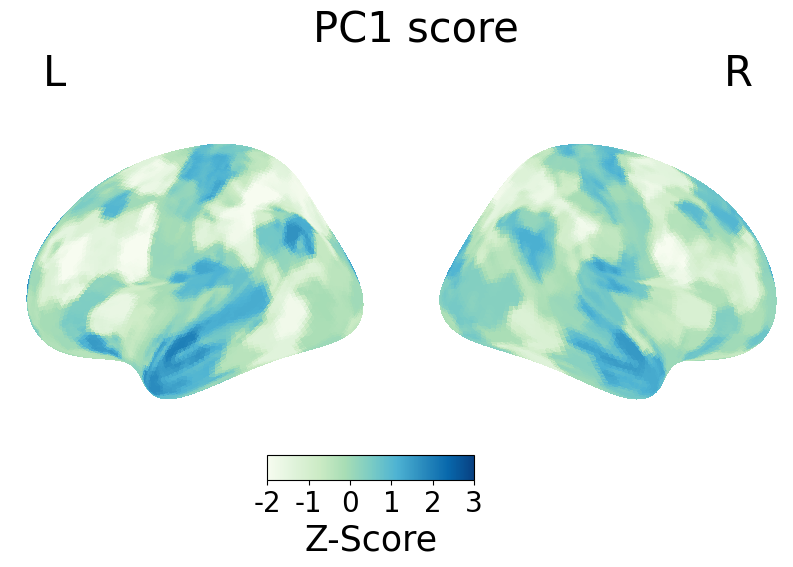

In [125]:
pattern = pd.read_csv(f'/data/dy/TIS_MDD/NeuroMap/pca_pattern_{schaefer}.csv')
pc1 = -pattern.values[0]
pc1_surf = parcel_to_surface(pc1,f"schaefer_{schaefer}_fsa5")
plot_nilearn(zscore(pc1),title='PC1 score',cmap_color='GnBu')

In [126]:
## Spin-test null distribution
rotated = nulls.alexander_bloch(pc1_surf, atlas='fsaverage', density='10k',n_perm=1500)

### FC gradient

In [127]:
margulies2016 = fetch_annotation(source='margulies2016') 


[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [secondary]:
    

  For {'source': 'margulies2016', 'desc': 'fcgradient02', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [se

Correlation: r = 0.13, p = 0.2398


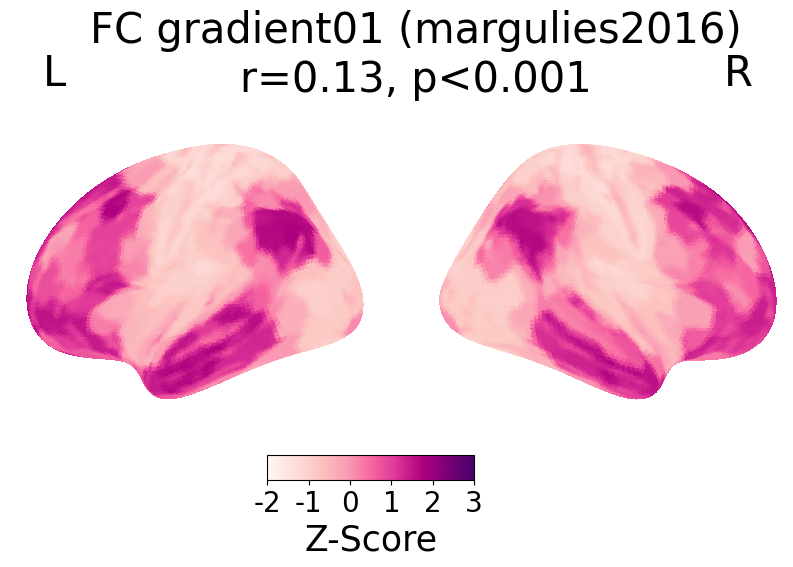

In [128]:
gradient_fsLR = margulies2016[('margulies2016', 'fcgradient01', 'fsLR', '32k')]
gradient_fsa5 = transforms.fslr_to_fsaverage(gradient_fsLR, '10k')
gradient_surf = np.hstack((gradient_fsa5[0].agg_data(),gradient_fsa5[1].agg_data()))
gradient = surface_to_parcel(gradient_surf,schaefer)

corr, pval = stats.compare_images(pc1_surf, gradient_surf, nulls=rotated)
print(f'Correlation: r = {corr:.02f}, p = {pval:.04f}')
plot_nilearn(zscore(gradient),title=f'FC gradient01 (margulies2016)\nr={np.abs(corr):.2f}, p<0.001',cmap_color='RdPu')

### cognitive PC1

In [129]:
neurosynth = fetch_annotation(source='neurosynth') 


[References] Please cite the following papers if you are using this data:

  For {'source': 'neurosynth', 'desc': 'cogpc1', 'space': 'MNI152', 'res': '2mm'}:
  [primary]:
    Tal Yarkoni, Russell A Poldrack, Thomas E Nichols, David C Van Essen, and Tor D Wager. Large-scale automated synthesis of human functional neuroimaging data. Nature Methods, 8(8):665, 2011.
  [secondary]:
    Russell A Poldrack, Aniket Kittur, Donald Kalar, Eric Miller, Christian Seppa, Yolanda Gil, D Stott Parker, Fred W Sabb, and Robert M Bilder. The cognitive atlas: toward a knowledge foundation for cognitive neuroscience. Frontiers Neuroinform, 5:17, 2011.


Correlation: r = 0.33, p = 0.0020


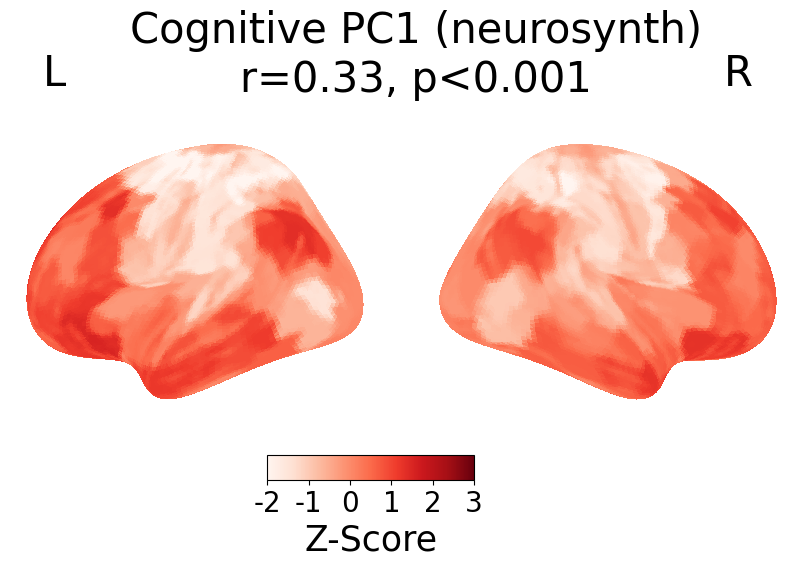

In [130]:
cogPC1_fsa5 = transforms.mni152_to_fsaverage(neurosynth, '10k')
cogPC1_surf = -np.hstack((cogPC1_fsa5[0].agg_data(),cogPC1_fsa5[1].agg_data()))
cogPC1 = surface_to_parcel(cogPC1_surf,schaefer)
corr, pval = stats.compare_images(pc1_surf, cogPC1_surf, nulls=rotated)
print(f'Correlation: r = {corr:.02f}, p = {pval:.04f}')
plot_nilearn(zscore(cogPC1),title=f'Cognitive PC1 (neurosynth)\nr={np.abs(corr):.02f}, p<0.001',cmap_color='Reds')